In [33]:
import matplotlib.pyplot as plt
import matplotlib
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml
import pathlib

import pickle
import pathlib

import mlflow

matplotlib.rcParams.update({'font.size': 14})

In [34]:
from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 23
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/doe4rl")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/experiments/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(path_mlruns)

# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    # list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    # assert len(list_glob_config) == 1, "More than one config file in the directory."

    # name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    # assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    # path_run_config_yaml = list_glob_config[0]

    dict_config_temp = mlflow.get_run(name_id).data.params
    nested_dict_config[name_id] = dict_config_temp
    list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))

    # with open(path_run_config_yaml, "r") as file:
    # Get the config file as a dictionary
    # dict_config_temp = yaml.safe_load(file)
    # Add the config file to the nested dictionary
    # nested_dict_config[name_id] = dict_config_temp
    # Flatten the config file for easier check
    # list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    # del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name",
                               "_id"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

Number of runs: 40 

XP id: 23 

Set of non unique keys: {'alg_n_semimarkov_dt', '_id', 'seed'} 

First config file: 0451918845904d82976880025961c9f9 

path_sampling_noise: '0.01'
name: 2023_12_01_lorenz_new_action_10_ep_length_300_num_iters_200
env_environment_parameters_dict_reward_config_control_penalty_parameters_control_penalty_scale: '0.0'
env_environment_parameters_dict_pde_config_control_step_freq: '1'
num_eval_trials: '5'
eigmpc_nsamps: '25'
env_environment_parameters_dict_pde_config_ep_length: '300'
env_mpc_n_elites: '1'
alg_sample_all_states: 'False'
env_tf_precision: '64'
env_environment_parameters_dict_scaling_constants_state: '1'
test_mpc_n_elites: '1'
alg_learn_reward: 'False'
alg_open_loop_mpc: 'False'
normalize_env: 'True'
env_environment_parameters_dict_pde_config_sigma: '10'
test_mpc_actions_per_plan: '1'
mpc_planning_horizon: '2'
n_paths: '15'
test_mpc_beta: '1'
env_eigmpc_actions_per_plan: '1'
env_environment_parameters_dict_scaling_constants_observation: '1'
sampl

In [35]:
(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 # .groupby(["seed", "alg_n_semimarkov_dt"])
 # .loc[:, ["alg_num_iters", "crop_to_domain", "project_to_domain", "alg_n_semimarkov_dt", "seed", "name"]]
 .loc[:, ["alg_num_iters", "alg_n_semimarkov_dt", "seed", "name"]]
 .nunique()

 )

alg_num_iters           1
alg_n_semimarkov_dt     4
seed                   10
name                    1
dtype: int64

In [36]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }
# Get the first dict_config
dict_config_ref = nested_dict_config[list_id_hash[0]]
# Length of the exploration trajectory
length_trajectory = int(dict_config_ref["num_iters"]) + 1
n_eval_trajectory = int(dict_config_ref["num_eval_trials"])
# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

        list_array = []
        eval_frequency = int(nested_dict_config[name_id]["eval_frequency"])

        list_excluded_columns_reshape = ["Acquisition Function Value",
                                         "mean_difference_state_boostrap",
                                         "n_corresponding_dt"]

        dict_temp = \
            {name_column: pd.Series(
                dict_data[name_column],
                index=([0, ] + list(np.arange(1, length_trajectory, step=eval_frequency, dtype=int))))

                for name_column in list_name_columns_learning
                if name_column not in list_excluded_columns_reshape}
        # Add the excluded columns without reshaping
        dict_temp.update(
            {name_column: pd.Series(dict_data[name_column], index=np.arange(length_trajectory - 1))
             for name_column in list_excluded_columns_reshape})
        df_learning_data_temp = (
            pd.DataFrame(dict_temp)
            .explode("Eval Returns")
            .reset_index(names=["iteration"])
            .rename(columns=dict_columns_learning_renaming_map)
        )

    list_df_learning_data.append(df_learning_data_temp)

In [37]:
# Get the list of the delay mode
list_action_delay_mode = [int(nested_dict_config[name_id]["alg_n_semimarkov_dt"])
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [38]:
df_learning_data.describe()

,iteration,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
count,24160.000000,20200.000000,2.020000e+04,20200.000000,2.020000e+04,20200.000000,20200.000000,24160.000000,2.416000e+04,24160.000000
mean,99.172185,100.990099,7.300645e-04,50.581612,4.423089e-04,-5.665934,-2.757131,2.591405,7.233646e-03,2.354719
std,58.110002,58.294063,1.658488e-03,5.080724,1.286119e-03,0.260685,0.000557,0.918082,2.955569e-02,1.877450
min,0.000000,1.000000,4.311491e-09,41.228044,8.262073e-09,-6.260964,-2.763149,0.500648,0.000000e+00,1.000000
25%,49.000000,51.000000,4.586108e-07,46.870602,3.272702e-07,-5.864393,-2.757139,1.845969,2.312965e-17,1.000000
50%,99.000000,101.000000,1.169020e-04,50.074299,3.549294e-05,-5.634590,-2.756920,2.543077,1.166093e-04,2.000000
75%,149.000000,151.000000,7.116752e-04,53.895987,3.084643e-04,-5.485530,-2.756834,3.209479,1.318169e-03,3.000000
max,199.000000,200.000000,2.664696e-02,62.329026,2.205879e-02,-5.216473,-2.756819,6.594208,4.839206e-01,8.000000


In [39]:
n_eval_trajectory = int(nested_dict_config[list_id_hash[0]]["num_eval_trials"])

(df_learning_data
 .infer_objects()
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"]))

iteration   eval_returns  \
run_id                           action_delay_mode                             
0451918845904d82976880025961c9f9 1                          0 -283832.725733   
                                 1                          0 -282786.619312   
                                 1                          0 -282541.721339   
                                 1                          0 -280825.758757   
                                 1                          0 -283185.713256   
...                                                       ...            ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                        199 -150483.039324   
                                 4                        199  -96608.415603   
                                 4                        199 -151614.314298   
                                 4                        199 -219554.768314   
                                 4                        199 -167379.661669   

                                                    eval_ndata  \
run_id                           action_delay_mode               
0451918845904d82976880025961c9f9 1                         1.0   
                                 1                         1.0   
                                 1                         1.0   
                                 1                         1.0   
                                 1                         1.0   
...                                                        ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                       200.0   
                                 4                       200.0   
                                 4                       200.0   
                                 4                       200.0   
                                 4                       200.0   

                                                    model_mse_current_real_mpc  \
run_id                           action_delay_mode                               
0451918845904d82976880025961c9f9 1                                3.055810e-04   
                                 1                                3.055810e-04   
                                 1                                3.055810e-04   
                                 1                                3.055810e-04   
                                 1                                3.055810e-04   
...                                                                        ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                                6.102041e-08   
                                 4                                6.102041e-08   
                                 4                                6.102041e-08   
                                 4                                6.102041e-08   
                                 4                                6.102041e-08   

                                                    model_mse_random_test_set  \
run_id                           action_delay_mode                              
0451918845904d82976880025961c9f9 1                                  52.584110   
                                 1                                  52.584110   
                                 1                                  52.584110   
                                 1                                  52.584110   
                                 1                                  52.584110   
...                                                                       ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                                  53.218719   
                                 4                                  53.218719   
                                 4                                  53.218719   
                                 4                                  53.218719   
                                 4                                  53.218719   

                               

##### Plotting metrics from pickle data

================== eig ==================


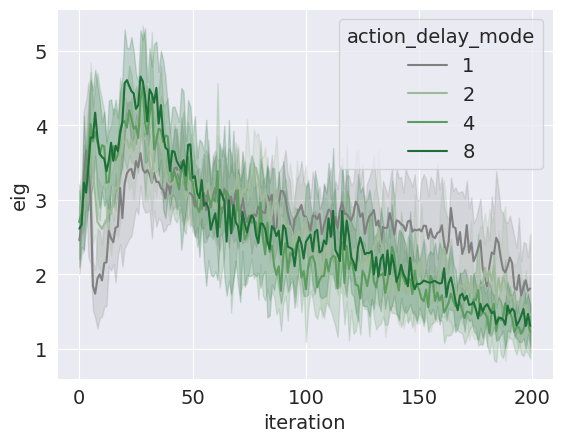

================== eval_returns ==================


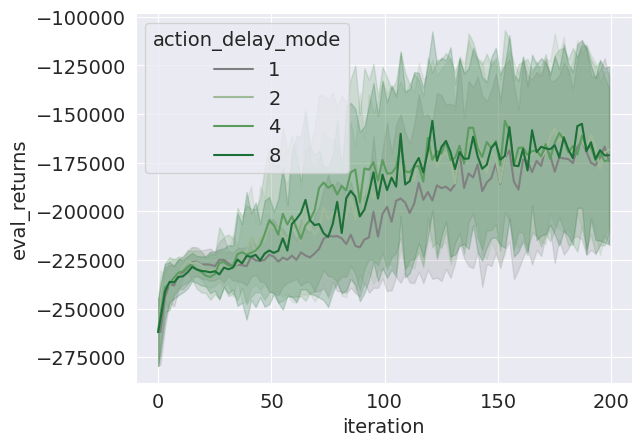

================== mean_difference_state_bootstrap ==================


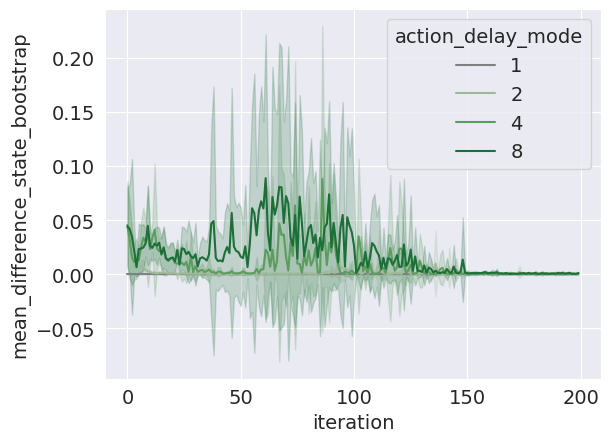

================== n_corresponding_dt ==================


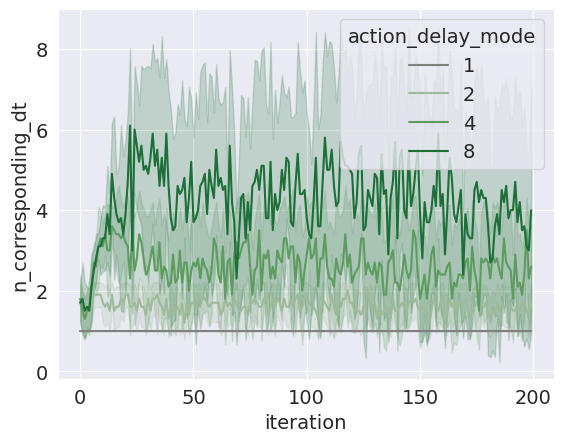

================== model_mse_current_real_mpc ==================


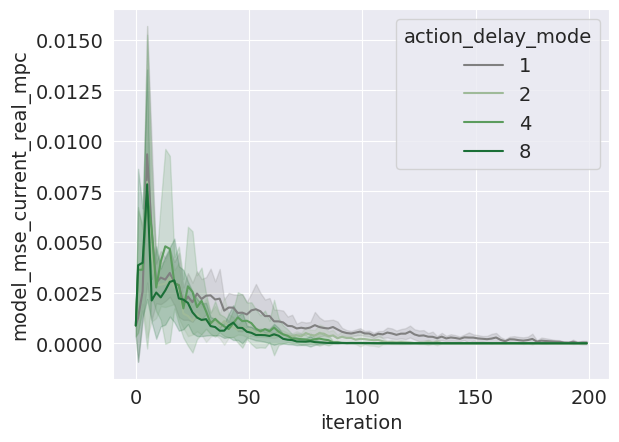

================== model_mse_random_test_set ==================


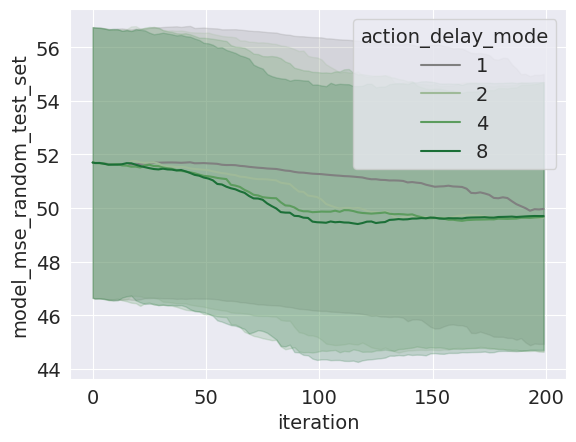

================== model_mse_gt_mpc ==================


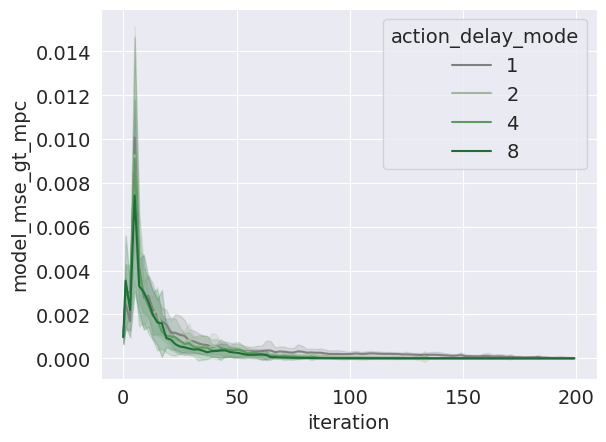

================== model_likelihood_random_test_set ==================


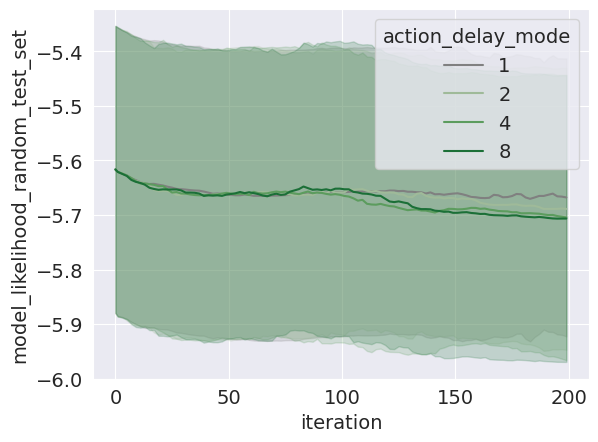

================== model_likelihood_gt_mpc ==================


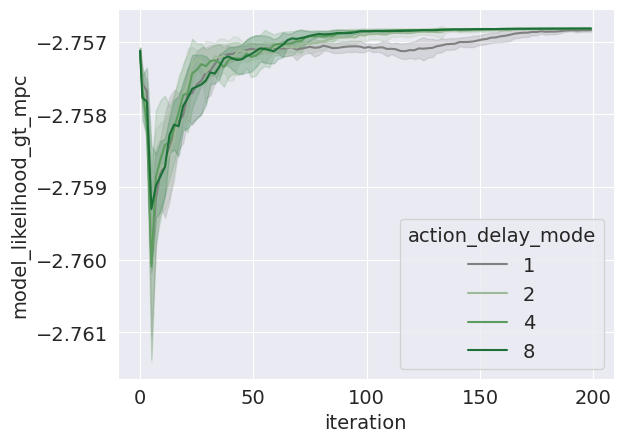

================== eval_ndata ==================


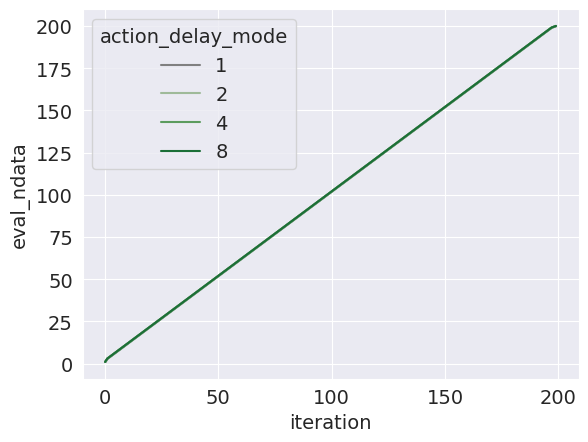

In [40]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Greens", len(set(list_action_delay_mode)) - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.8
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["Grey"] + sns_other_palette
# list_color_palette = ["black"] + sns.color_palette("Greens", len(list_action_delay_mode) - 1).as_hex()
df_plot = df_learning_data.reset_index()

list_columns_plot = ["eig", "eval_returns", "mean_difference_state_bootstrap", "n_corresponding_dt",
                     "model_mse_current_real_mpc", "model_mse_random_test_set",
                     "model_mse_gt_mpc", "model_likelihood_random_test_set", "model_likelihood_gt_mpc", "eval_ndata"]

plt.close()
for name_column in list_columns_plot:
    print(f"================== {name_column} ==================")
    g = sns.lineplot(data=df_plot,
                     x="iteration",
                     y=name_column,
                     hue="action_delay_mode",
                     errorbar="sd",
                     legend="full",
                     palette=list_color_palette)
    plt.show()
    # Save the   figure
    # g.figure.savefig(f"/home/hosseinkhan/Downloads/temp_imgs/{name_column}.png")
    # plt.close()

### Objective function evolution

[Text(0.5, 0, 'Sampling iteration   $n$'),
 Text(0, 0.5, 'Evaluation of Objective Function   $J^\\pi$'),
 Text(0.5, 1.0, 'Evolution of   $J^\\pi$   over the sampling iterations  $n$')]

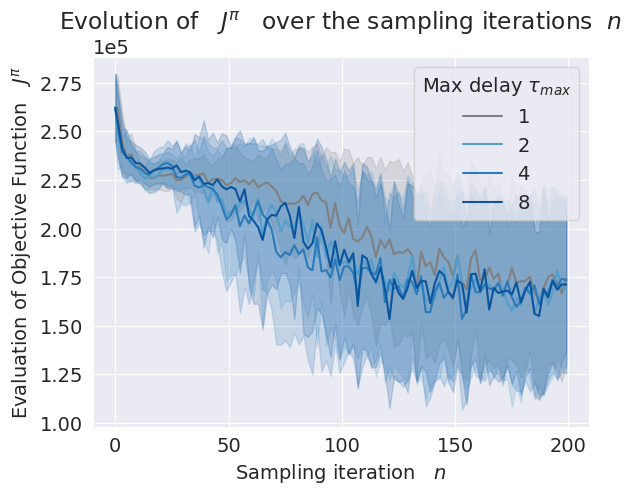

In [41]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Blues")[-(len(set(list_action_delay_mode)) - 1):]

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_latex_template_semimarkov/images"
folder_name = "objective_function_evolution"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)



# Increase darkness of all colors in palette
list_color_palette = ["Grey"] + sns_other_palette
df_plot = (df_learning_data
           .reset_index()
           .assign(eval_returns=lambda df: -df["eval_returns"].astype(float)))

g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y="eval_returns",
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
g.set(xlabel="Sampling iteration   $n$",
      ylabel="Evaluation of Objective Function   $J^\pi$",
      title="Evolution of   $J^\pi$   over the sampling iterations  $n$")
g.axes.get_legend().set_title("Max delay $\\tau_{max}$")
g.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.show()
# Save the figure
g.figure.savefig(f"{path_save_fig}/lorenz.png")
plt.close()

[Text(0.5, 0, 'Sampling iteration   $n$'),
 Text(0, 0.5, 'Interdecision time $\\tau_n$'),
 Text(0.5, 1.0, 'Evolution of   $\\tau_n$   over the sampling iterations  $n$')]

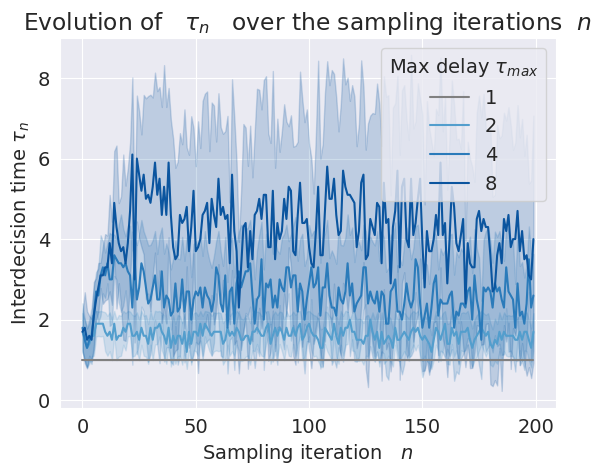

In [42]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Blues")[-(len(set(list_action_delay_mode)) - 1):]

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_latex_template_semimarkov/images"
folder_name = "interdecision_time_evolution"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

# Increase darkness of all colors in palette
list_color_palette = ["Grey"] + sns_other_palette
df_plot = (df_learning_data
           .reset_index()
           .assign(eval_returns=lambda df: -df["eval_returns"].astype(float)))

g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y="n_corresponding_dt",
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
g.set(xlabel="Sampling iteration   $n$",
      ylabel="Interdecision time $\\tau_n$",
      title="Evolution of   $\\tau_n$   over the sampling iterations  $n$")
g.axes.get_legend().set_title("Max delay $\\tau_{max}$")

plt.show()
# Save the figure
g.figure.savefig(f"{path_save_fig}/lorenz.png")
# plt.close()

[Text(0.5, 0, 'Sampling iteration   $n$'),
 Text(0, 0.5, 'Expected Information Gain   $EIG_n$'),
 Text(0.5, 1.0, 'Evolution of   $EIG_n$   over the sampling iterations  $n$')]

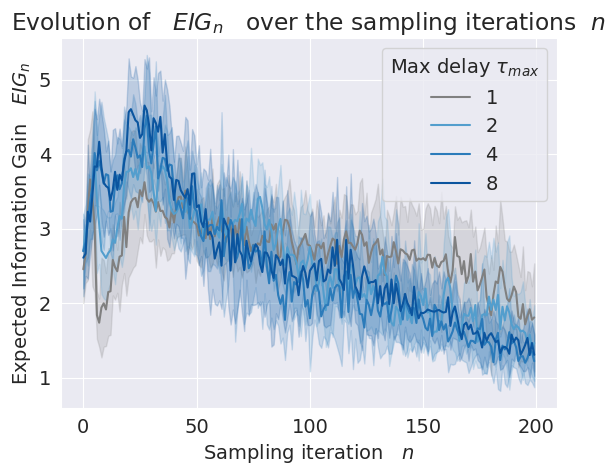

In [43]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Blues")[-(len(set(list_action_delay_mode)) - 1):]

path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_latex_template_semimarkov/images"
folder_name = "eig_evolution"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

# Increase darkness of all colors in palette
list_color_palette = ["Grey"] + sns_other_palette
df_plot = (df_learning_data
           .reset_index()
           .assign(eval_returns=lambda df: -df["eval_returns"].astype(float)))

g = sns.lineplot(data=df_plot,
                 x="iteration",
                 y="eig",
                 hue="action_delay_mode",
                 errorbar="sd",
                 legend="full",
                 palette=list_color_palette)
g.set(xlabel="Sampling iteration   $n$",
      ylabel="Expected Information Gain   $EIG_n$",
      title="Evolution of   $EIG_n$   over the sampling iterations  $n$")
g.axes.get_legend().set_title("Max delay $\\tau_{max}$")

plt.show()
# Save the figure
g.figure.savefig(f"{path_save_fig}/lorenz.png")
plt.close()

In [44]:
import ast

dim_x = len(ast.literal_eval(nested_dict_config[list_id_hash[0]]["env_gp_alpha"]))
dim_u = len(ast.literal_eval(nested_dict_config[list_id_hash[0]]["env_gp_ls"])[0]) - dim_x

list_df_trajectory_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

    df_trajectory_data_temp = (pd.concat(
        [pd.DataFrame(np.array(dict_data["x"])[:, :dim_x]), pd.DataFrame(np.array(dict_data["x"])[:, dim_x:])],
        axis="columns",
        keys=["state", "action"],
        names=["component", "i"]).assign(n_corresponding_dt=[0] + list(np.array(dict_data["n_corresponding_dt"])),
                                         iteration_exploration=[0] + list(
                                             np.array(dict_data["n_corresponding_dt"]).cumsum()),
                                         seed=nested_dict_config[name_id]["seed"])
                               .rename_axis("iteration", axis="index")

                               )

    list_df_trajectory_data.append(df_trajectory_data_temp)

In [45]:
df_trajectory_data = (pd.concat(list_df_trajectory_data, keys=list_keys_tuple_id_action_delay_mode,
                                names=["run_id", "action_delay_mode"])
                      .infer_objects()
                      .convert_dtypes()
                      .astype({"seed": "category", "n_corresponding_dt": "category"})
                      )

In [46]:
df_trajectory_data

component                                                        state  \
i                                                                    0   
run_id                           action_delay_mode iteration             
0451918845904d82976880025961c9f9 1                 0         -0.085293   
                                                   1         -0.086326   
                                                   2         -0.081714   
                                                   3         -0.080768   
                                                   4          -0.07936   
...                                                                ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                 196       -0.049634   
                                                   197        0.031145   
                                                   198        0.104136   
                                                   199        0.142936   
                                                   200        0.073978   

component                                                               \
i                                                                    1   
run_id                           action_delay_mode iteration             
0451918845904d82976880025961c9f9 1                 0         -0.085208   
                                                   1         -0.084709   
                                                   2         -0.082314   
                                                   3         -0.082359   
                                                   4         -0.081049   
...                                                                ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                 196        0.059024   
                                                   197        0.051363   
                                                   198        0.151325   
                                                   199        0.135419   
                                                   200         0.01809   

component                                                               \
i                                                                    2   
run_id                           action_delay_mode iteration             
0451918845904d82976880025961c9f9 1                 0          0.268951   
                                                   1          0.272007   
                                                   2          0.267326   
                                                   3          0.263322   
                                                   4           0.25791   
...                                                                ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                 196        0.330276   
                                                   197        0.210281   
                                                   198        0.213525   
                                                   199        0.339936   
                                                   200        0.302205   

component                                                       action  \
i                                                                    0   
run_id                           action_delay_mode iteration             
0451918845904d82976880025961c9f9 1                 0         -0.699207   
                                                   1          0.859469   
                                                   2          0.292849   
                                                   3          0.433625   
                                                   4         -0.953253   
...                                                                ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 4                 196       -0.580295   
                                                   197        0.185241   
                                                   198        0.901775   
 

In [47]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "seed"], append=True)
 .groupby(["action_delay_mode", "iteration"])
 .mean()
 .loc[:, pd.IndexSlice[["state", "iteration_exploration"], :]]
 .set_index("iteration_exploration", append=True)
 .stack()
 .reset_index())

component,action_delay_mode,iteration,iteration_exploration,i,state
0,1,0,0.0,0,-0.084697
1,1,0,0.0,1,-0.08519
2,1,0,0.0,2,0.270077
3,1,1,1.0,0,-0.084709
4,1,1,1.0,1,-0.084542
...,...,...,...,...,...
2407,8,199,842.0,1,0.014753
2408,8,199,842.0,2,0.158668
2409,8,200,846.0,0,0.003848
2410,8,200,846.0,1,0.018582


Text(0.5, 1.0, 'Coordinate 0: $X^0$')

Text(0.5, 1.0, 'Coordinate 1: $X^1$')

Text(0.5, 1.0, 'Coordinate 2: $X^2$')

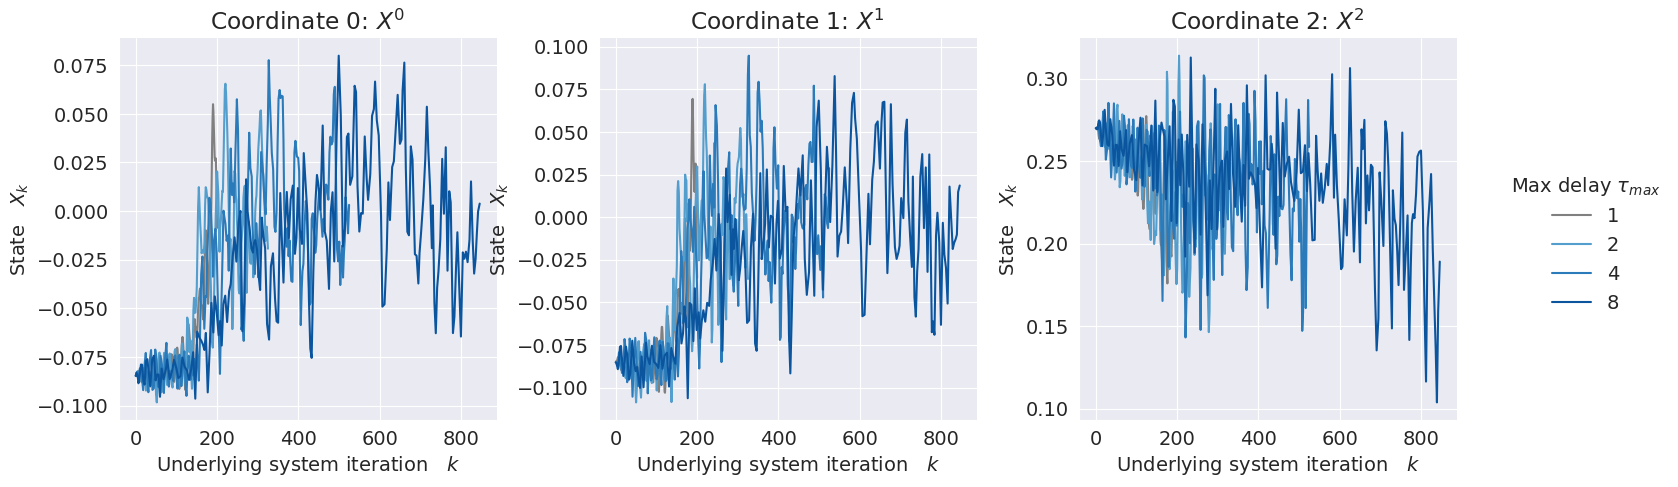

In [48]:
path_save_fig = "/home/hosseinkhan/Documents/work/phd/latex_documents/l4dc2024_latex_template_semimarkov/images"
folder_name = "exploration_trajectory"
path_save_fig = f"{path_save_fig}/{folder_name}"
pathlib.Path(path_save_fig).mkdir(parents=True, exist_ok=True)

df_plot = (df_trajectory_data
      .set_index(["n_corresponding_dt", "seed"], append=True)
      .groupby(["action_delay_mode", "iteration"])
      .mean()
      .loc[:, pd.IndexSlice[["state", "iteration_exploration"], :]]
      .set_index("iteration_exploration", append=True)
      .stack()
      .reset_index())

# Plot the data w.r.t to the mode of the delay
g = sns.relplot(data=df_plot,
                x="iteration_exploration",
                y="state",
                hue="action_delay_mode",
                col="i",
                col_wrap=dim_x,
                kind="line",
                facet_kws=dict(sharey=False),
                legend="full",
                palette=list_color_palette
                )

g.set(xlabel="Underlying system iteration   $k$",
      ylabel="State   $X_k$")
g.legend.set_title("Max delay $\\tau_{max}$")
for i, ax in enumerate(g.axes):
    ax.set_title(f"Coordinate {i}: $X^{i}$")
    
g.savefig(f"{path_save_fig}/lorenz.png")